<a href="https://colab.research.google.com/github/vinismachadoo/otimizacao-petroleo-offshore/blob/main/producao_bacia_campos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas -q
!pip install pulp -q

In [2]:
import pandas as pd
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import acos, cos, sin
from pulp import *

In [3]:
response = requests.get('http://hmlapp5.anp.gov.br/geoserver/oracleworskspace/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=oracleworskspace:CAMPOS_PRODUCAO_SIRGAS&outputFormat=JSON', verify=False)
campos_producao = gpd.GeoDataFrame.from_features(response.json()['features'], crs='EPSG:4326')

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [4]:
municipios_rj = gpd.read_file('https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/UFs/RJ/rj_municipios.zip')

In [5]:
bacia_campos = campos_producao[campos_producao.NOM_BACIA == 'Campos']

In [6]:
operadores = {
    'Shell Brasil Petróleo Ltda.': 'Shell Brasil',
    'Dommo Energia S.A': 'Dommo Energia',
    'Total E&P do Brasil Ltda.': 'Total E&P',
    'BW Energy Maromba do Brasil LTDA': 'BW Energy',
    'Petróleo Brasileiro S.A.': 'Petrobras',
    'Petro Rio O&G Exploração e Produção de Petróleo Ltda.': 'Petro Rio O&G',
    'Equinor Brasil Energia Ltda.': 'Equinor Brasil',
    'Perenco Petróleo e Gás do Brasil Ltda.': 'Perenco Brasil',
    'Petro Rio Jaguar Petróleo Ltda.': 'Petro Rio O&G'
}

bacia_campos.OPERADOR_C.replace(operadores, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [7]:
ueps_operacao = pd.read_csv('http://www.anp.gov.br/arquivos/dados-ep/ueps-operacao.csv', sep=';', header=1)
plataformas = ueps_operacao[ueps_operacao['Bacia '] == 'Campos '].set_index('Sigla')

In [8]:
plataformas.Operador.replace('Chevron Frade', 'Petro Rio O&G', inplace=True)

In [9]:
plataformas_latitude = plataformas.Latitude.str.replace(",",".").str.split(":", expand=True)
plataformas['latitude_decimal'] = plataformas_latitude[0].astype(int) - plataformas_latitude[1].astype(float) / 60 - plataformas_latitude[2].astype(float) / 3600
plataformas['latitude_radianos'] = np.deg2rad(plataformas['latitude_decimal'])

plataformas_longitude = plataformas.Longitude.str.replace(",",".").str.split(":", expand=True)
plataformas['longitude_decimal'] = plataformas_longitude[0].astype(int) - plataformas_longitude[1].astype(float) / 60 - plataformas_longitude[2].astype(float) / 3600
plataformas['longitude_radianos'] = np.deg2rad(plataformas['longitude_decimal'])

In [10]:
demanda_mapa = {
    'FPSO': 45,
    'FIXA': 45,
    'SEMI SUBMERSÍVEL': 73,
    'FPU': 55,
    'TLWP': 55
}
plataformas['demanda'] = plataformas.Tipo.map(demanda_mapa)

In [11]:
plataformas

,Nome,Bacia,Tipo,Operador,Latitude,Longitude,Lâmina D'água (m),Capacidade de Processamento Petróleo (bbl/dia),Capacidade de Processamento Gás (Mil m³/dia),latitude_decimal,latitude_radianos,longitude_decimal,longitude_radianos,demanda
Sigla,,,,,,,,,,,,,,
CAPX,FPSO CAPIXABA,Campos,FPSO,Petrobras,"-21:14:16,783","-39:57:46,397",1350,110000,3200,-21.237995,-0.370673,-39.962888,-0.697484,45
FCDA,FPSO CIDADE DE ANCHIETA,Campos,FPSO,Petrobras,"-21:20:16,965","-40:03:27,174",1221,100000,3500,-21.338046,-0.372419,-40.057548,-0.699136,45
FPCGZ,FPSO Cidade de Campos dos Goytacazes,Campos,FPSO,Petrobras,"-22:57:12,165","-40:43:31,966",765,150000,3500,-22.953379,-0.400612,-40.725546,-0.710795,45
FPNT,FPSO CIDADE DE NITEROI,Campos,FPSO,Petrobras,"-22:29:47,688","-39:56:14,785",1370,100000,3500,-22.496580,-0.392639,-39.937440,-0.697040,45
FPSO ESP SANTO,FPSO ESPIRITO SANTO,Campos,FPSO,Shell Brasil,"-21:12:30,854","-39:44:33,774",1775,100000,1400,-21.208571,-0.370159,-39.742715,-0.693641,45
FPSO FLUMINENSE,FPSO Fluminense,Campos,FPSO,Shell Brasil,"-22:38:57,206","-40:25:43,286",607,70000,2124,-22.649224,-0.395304,-40.428691,-0.705614,45
FPSO FRADE,FPSO FRADE,Campos,FPSO,Petro Rio O&G,"-21:53:03,196","-39:51:30,700",1065,100000,3000,-21.884221,-0.381952,-39.858528,-0.695663,45
OSX1,FPSO_OSX1,Campos,FPSO,Dommo Energia,"-23:32:07,003","-41:26:12,643",130,40000,1500,-23.535279,-0.410768,-41.436845,-0.723209,45
OSX3,FPSO_OSX3,Campos,FPSO,Dommo Energia,"-23:08:08,977","-41:04:24,717",105,100000,1500,-23.135827,-0.403796,-41.073533,-0.716868,45


In [12]:
aeroportos_data = {
    'Sigla': ['SBCP', 'SBME', 'SBFS', 'SBCB'],
    'maxFrota': [20, 20, 10, 20],
    'maxPatio': [364, 364, 182, 364],
    'Latitude': ['-21:42:04', '-22:20:34', '-22:01:44', '-22:55:15'],
    'Longitude': ['-41:18:28', '-41:45:50', '-41:04:11', '-42:04:17']
}
aeroportos = pd.DataFrame(aeroportos_data).set_index('Sigla')

aeroportos_latitude = aeroportos.Latitude.str.replace(",",".").str.split(":", expand=True)
aeroportos['latitude_decimal'] = aeroportos_latitude[0].astype(int) - aeroportos_latitude[1].astype(float) / 60 - aeroportos_latitude[2].astype(float) / 3600
aeroportos['latitude_radianos'] = np.deg2rad(aeroportos['latitude_decimal'])

aeroportos_longitude = aeroportos.Longitude.str.replace(",",".").str.split(":", expand=True)
aeroportos['longitude_decimal'] = aeroportos_longitude[0].astype(int) - aeroportos_longitude[1].astype(float) / 60 - aeroportos_longitude[2].astype(float) / 3600
aeroportos['longitude_radianos'] = np.deg2rad(aeroportos['longitude_decimal'])

In [13]:
aeroportos

,maxFrota,maxPatio,Latitude,Longitude,latitude_decimal,latitude_radianos,longitude_decimal,longitude_radianos
Sigla,,,,,,,,
SBCP,20,364,-21:42:04,-41:18:28,-21.701111,-0.378756,-41.307778,-0.720957
SBME,20,364,-22:20:34,-41:45:50,-22.342778,-0.389955,-41.763889,-0.728917
SBFS,10,182,-22:01:44,-41:04:11,-22.028889,-0.384477,-41.069722,-0.716802
SBCB,20,364,-22:55:15,-42:04:17,-22.920833,-0.400044,-42.071389,-0.734284


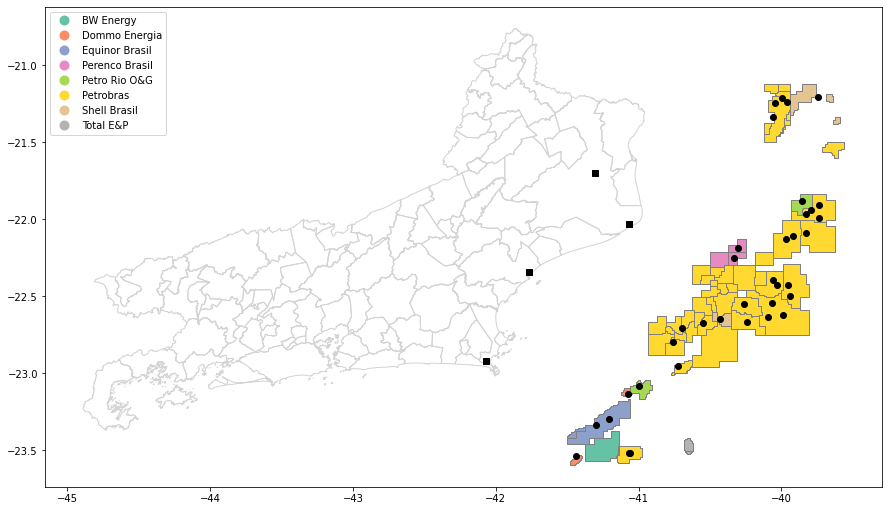

In [14]:
fig, ax = plt.subplots(figsize = (15,10))
bacia_campos.plot(ax=ax, ec='gray', column='OPERADOR_C', cmap='Set2', legend=True, legend_kwds={'loc': 'upper left'})
municipios_rj.plot(ax=ax, fc='None', ec='lightgray')
ax.scatter(plataformas['longitude_decimal'], plataformas['latitude_decimal'], color='black')
ax.scatter(aeroportos['longitude_decimal'], aeroportos['latitude_decimal'], color='black', marker='s')

plt.show()

In [15]:
OPERADORES = set(plataformas.Operador.unique())
PLATAFORMAS = set(plataformas.index)
AEROPORTOS = set(aeroportos.index)

In [16]:
def calcula_distancia(p,a):
    d = 2*6378*acos(
        cos(
            plataformas['longitude_radianos'][p] - aeroportos['longitude_radianos'][a]
        )*cos(
            plataformas['latitude_radianos'][p]
        )*cos(
            aeroportos['latitude_radianos'][a]
        )+sin(
            plataformas['latitude_radianos'][p]
        )*sin(
            aeroportos['latitude_radianos'][a]
        ))
    return d

distancia = {}
for p in PLATAFORMAS:
    dd = {a:calcula_distancia(p,a) for a in AEROPORTOS}
    distancia[p] = dd

In [17]:
permicao = {}
for o in OPERADORES:
    oo = {p: (1 if plataformas.Operador[p] == o else 0) for p in PLATAFORMAS}
    permicao[o] = oo

In [18]:
helicoptero = {
    'assentos': 13,
    'maxVoos': 14,
}

In [19]:
pb = LpProblem('Facility', LpMinimize)
x = LpVariable.dicts('x', (OPERADORES, PLATAFORMAS, AEROPORTOS), cat='Binary')
y = LpVariable.dicts('y', (OPERADORES, AEROPORTOS), cat='Integer')
z = LpVariable.dicts('z', (OPERADORES, PLATAFORMAS, AEROPORTOS), cat='Integer')
pb += lpSum([[[distancia[p][a] * z[o][p][a] + 1_000_000 * y[o][a] for o in OPERADORES] for p in PLATAFORMAS] for a in AEROPORTOS])

for o in OPERADORES:
    for p in PLATAFORMAS:
        # Uma plataforma tem que ser atendida por um, e apenas um, aeroporto
        pb += lpSum([x[o][p][a] for a in AEROPORTOS]) == permicao[o][p]
        # O aeroporto SBFS só pode atender plataformas da Petrobras
        pb += x[o][p]['SBFS'] <= permicao['Petrobras'][p]
        for a in AEROPORTOS:
            pb += z[o][p][a] >= plataformas['demanda'][p] * x[o][p][a] / helicoptero['assentos']

for a in AEROPORTOS:
    # Número limitado de decolagens no aeroporto
    pb += lpSum([[z[o][p][a] for o in OPERADORES] for p in PLATAFORMAS]) <= aeroportos['maxPatio'][a]
    # Número limitado de frota disponivel no aeroporto
    pb += lpSum([y[o][a] for o in OPERADORES]) <= aeroportos['maxFrota'][a]
    for o in OPERADORES:
        # Existe uma quantidade limite de voos que uma aeronave pode fazer por semana
        pb += lpSum([z[o][p][a] for p in PLATAFORMAS]) <= y[o][a] * helicoptero['maxVoos']

pb.solve()
print("Status:", LpStatus[pb.status])

Status: Optimal


In [20]:
for v in pb.variables():
    if value(v) >= 1:
        print(v, "=", value(v))

x_Dommo_Energia_OSX1_SBCB = 1.0
x_Dommo_Energia_OSX3_SBCB = 1.0
x_Equinor_Brasil_PEREGRINO_A_SBCB = 1.0
x_Equinor_Brasil_PEREGRINO_B_SBCB = 1.0
x_Perenco_Brasil_PPG_1A_SBCP = 1.0
x_Perenco_Brasil_PVM_3_SBCP = 1.0
x_Petro_Rio_O&G_FPSO_FRADE_SBCP = 1.0
x_Petro_Rio_O&G_POLVO_A_SBCP = 1.0
x_Petrobras_CAPX_SBFS = 1.0
x_Petrobras_FCDA_SBFS = 1.0
x_Petrobras_FPCGZ_SBCB = 1.0
x_Petrobras_FPNT_SBFS = 1.0
x_Petrobras_PCE_1_SBFS = 1.0
x_Petrobras_PPM_1_SBFS = 1.0
x_Petrobras_P_08_SBFS = 1.0
x_Petrobras_P_18_SBFS = 1.0
x_Petrobras_P_19_SBFS = 1.0
x_Petrobras_P_25_SBFS = 1.0
x_Petrobras_P_31_SBFS = 1.0
x_Petrobras_P_40_SBFS = 1.0
x_Petrobras_P_43_SBFS = 1.0
x_Petrobras_P_48_SBFS = 1.0
x_Petrobras_P_50_SBFS = 1.0
x_Petrobras_P_51_SBFS = 1.0
x_Petrobras_P_52_SBFS = 1.0
x_Petrobras_P_53_SBFS = 1.0
x_Petrobras_P_54_SBFS = 1.0
x_Petrobras_P_55_SBFS = 1.0
x_Petrobras_P_56_SBFS = 1.0
x_Petrobras_P_57_SBFS = 1.0
x_Petrobras_P_58_SBFS = 1.0
x_Petrobras_P_61_SBCB = 1.0
x_Petrobras_P_62_SBFS = 1.0
x_Petrobras

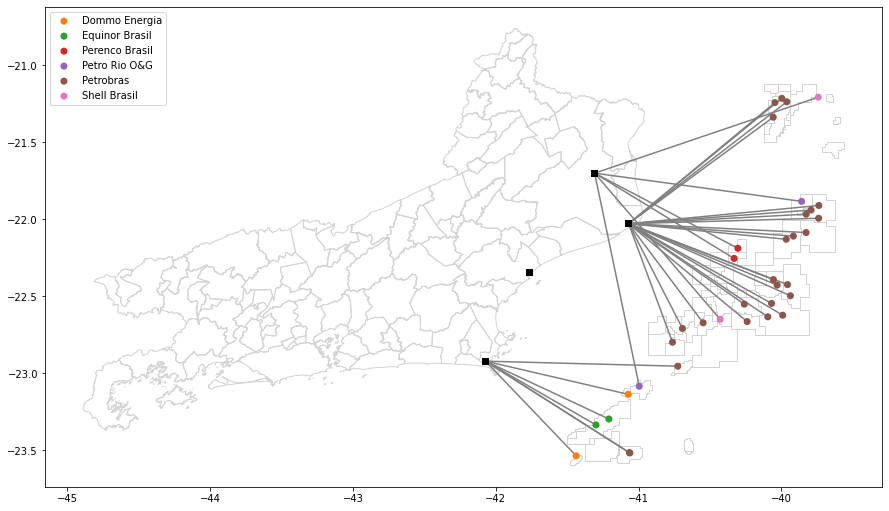

In [21]:
fig, ax = plt.subplots(figsize = (15,10))
bacia_campos.plot(ax=ax, fc='None', ec='lightgray')
municipios_rj.plot(ax=ax, fc='None', ec='lightgray')
sns.scatterplot(x='longitude_decimal', y='latitude_decimal', data=aeroportos, ax=ax, marker='s', s=50, ec='None', fc='black', zorder=2)
for name, group in plataformas.groupby('Operador'):
    sns.scatterplot(x='longitude_decimal', y='latitude_decimal', data=group, label=name, ax=ax, s=50, ec='None', zorder=2)
for o in OPERADORES:
    for p in PLATAFORMAS:
        for a in AEROPORTOS:
            if value(x[o][p][a]) == 1:
                ax.plot([plataformas.longitude_decimal[p], aeroportos.longitude_decimal[a]],
                        [plataformas.latitude_decimal[p], aeroportos.latitude_decimal[a]], color='gray', zorder=1)
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()